In [130]:
# TODO: 
#   1. Refactor code
#   2. Implement skewness handling methods
#   3. Separate code into PCR and RFS files
#   4. Implement hyperparameter tuning
#   5. Implement observability and tracking to measure performance across difference variations
#   6. Improve imputation for categorical variables
#   7. Use appropriate metrics for regression and classification


# Data Ingestion

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_excel('TrainDataset2024.xls')

df.head()

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1,144.0,41.0,0,0,0,1,3,3,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,TRG002178,0,142.0,39.0,1,1,0,0,3,3,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,TRG002204,1,135.0,31.0,0,0,0,1,2,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,TRG002206,0,12.0,35.0,0,0,0,1,3,3,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,TRG002210,0,109.0,61.0,1,0,0,0,2,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


# EDA

- The dataset has 121 columns with 2 target variables (pCR outcome) and RelapseFreeSurvival (outcome) and 118 features.
- 11 of those features are clincal and the remaining 107 features are MRI-based features.
- We have 400 data records

In [4]:
print('shape:', df.shape)

print('info:', df.info())

print('describe:', df.describe())

shape: (400, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 121 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(12), object(1)
memory usage: 378.3+ KB
info: None
describe:        pCR (outcome)  RelapseFreeSurvival (outcome)         Age          ER  \
count     400.000000                     400.000000  400.000000  400.000000   
mean       12.697500                      56.000208   51.804674    0.547500   
std       111.107417                      27.137584   10.948522    0.498362   
min         0.000000                       0.000000   23.000000    0.000000   
25%         0.000000                      38.000000   44.516769    0.000000   
50%         0.000000                      55.000000   51.019507    1.000000   
75%         0.000000                      73.000000   60.000000    1.000000   
max       999.000000                     144.000000   79.603012    1.000000   

              PgR        HER2  TrippleNegative  ChemoGrade

## Outlier Detection

In [5]:
def detect_and_handle_outliers(df, method="IQR", cap=False, visualize=False, mode="count"):
    """
    Detects and handles outliers in continuous variables.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - method (str): The outlier detection method ('IQR' or 'Z-Score').
    - cap (bool): If True, caps outliers instead of removing them.
    - visualize (bool): If True, visualizes outliers using boxplots.

    Returns:
    - df (pd.DataFrame): The dataframe with outliers handled.
    """
    temp_df = df.drop(['ID', 'RelapseFreeSurvival (outcome)', 'Age'], axis=1)
    
    continuous_cols = list(temp_df.columns[(temp_df.nunique()>10)])
    if mode == "count":
        outlier_counts = {}
    
    for col in continuous_cols:

        if method == "IQR":
            # Calculate IQR
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Detect outliers
            outliers = (df[col] < lower_bound) | (df[col] > upper_bound)

        elif method == "Z-Score":
            # Calculate Z-scores
            mean = df[col].mean()
            std = df[col].std()
            z_scores = (df[col] - mean) / std
            outliers = (z_scores < -3) | (z_scores > 3)

        
        else:
            raise ValueError("Invalid method. Choose 'IQR' or 'Z-Score'.")

        if mode == "count":
            outlier_counts[col] = outliers.sum()
        
        # Handle outliers
        if cap:
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        else:
            df = df[~outliers]  # Remove rows with outliers
        
        # Visualization
        if visualize:
            plt.figure(figsize=(8, 4))
            sns.boxplot(x=df[col])
            plt.title(f"Outlier Handling for {col}")
            plt.grid()
            plt.show()
    
    if mode == "count":
        outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=["Column", "Outlier_Count"])
        outlier_counts_df = outlier_counts_df.sort_values(by="Outlier_Count", ascending=False).reset_index(drop=True)
        return outlier_counts_df
    
    return df


In [6]:
df.shape

(400, 121)

In [7]:
detect_and_handle_outliers(df, method="Z-Score", mode="handle").shape

(186, 121)

In [8]:
detect_and_handle_outliers(df, method="IQR", mode="handle").shape

(96, 121)

In [9]:
iqr_outlier_count_df = detect_and_handle_outliers(df, method="IQR")
iqr_outlier_count_df[(iqr_outlier_count_df['Outlier_Count']>0)]

,Column,Outlier_Count
0,original_shape_MeshVolume,15
1,original_shape_SurfaceVolumeRatio,15
2,original_shape_LeastAxisLength,13
3,original_ngtdm_Coarseness,13
4,original_shape_Maximum2DDiameterRow,12
5,original_firstorder_Kurtosis,12
6,original_glcm_Imc1,12
7,original_shape_MajorAxisLength,11
8,original_glszm_GrayLevelNonUniformity,11
9,original_glszm_LargeAreaEmphasis,10


In [10]:
z_score_outlier_count_df = detect_and_handle_outliers(df, method="Z-Score")
z_score_outlier_count_df[(z_score_outlier_count_df['Outlier_Count']>0)]

,Column,Outlier_Count
0,original_glszm_LargeAreaHighGrayLevelEmphasis,10
1,original_shape_MeshVolume,9
2,original_glszm_GrayLevelNonUniformityNormalized,9
3,original_firstorder_Energy,8
4,original_ngtdm_Strength,7
5,original_firstorder_90Percentile,7
6,original_glszm_GrayLevelVariance,6
7,original_firstorder_TotalEnergy,6
8,original_shape_MinorAxisLength,6
9,original_glcm_Imc1,6


In [11]:

iqr_outlier_count_df[(iqr_outlier_count_df['Outlier_Count']>0)]['Outlier_Count'].sum()

304

In [12]:
z_score_outlier_count_df[(z_score_outlier_count_df['Outlier_Count']>0)]['Outlier_Count'].sum()

214

## Corelation Plots

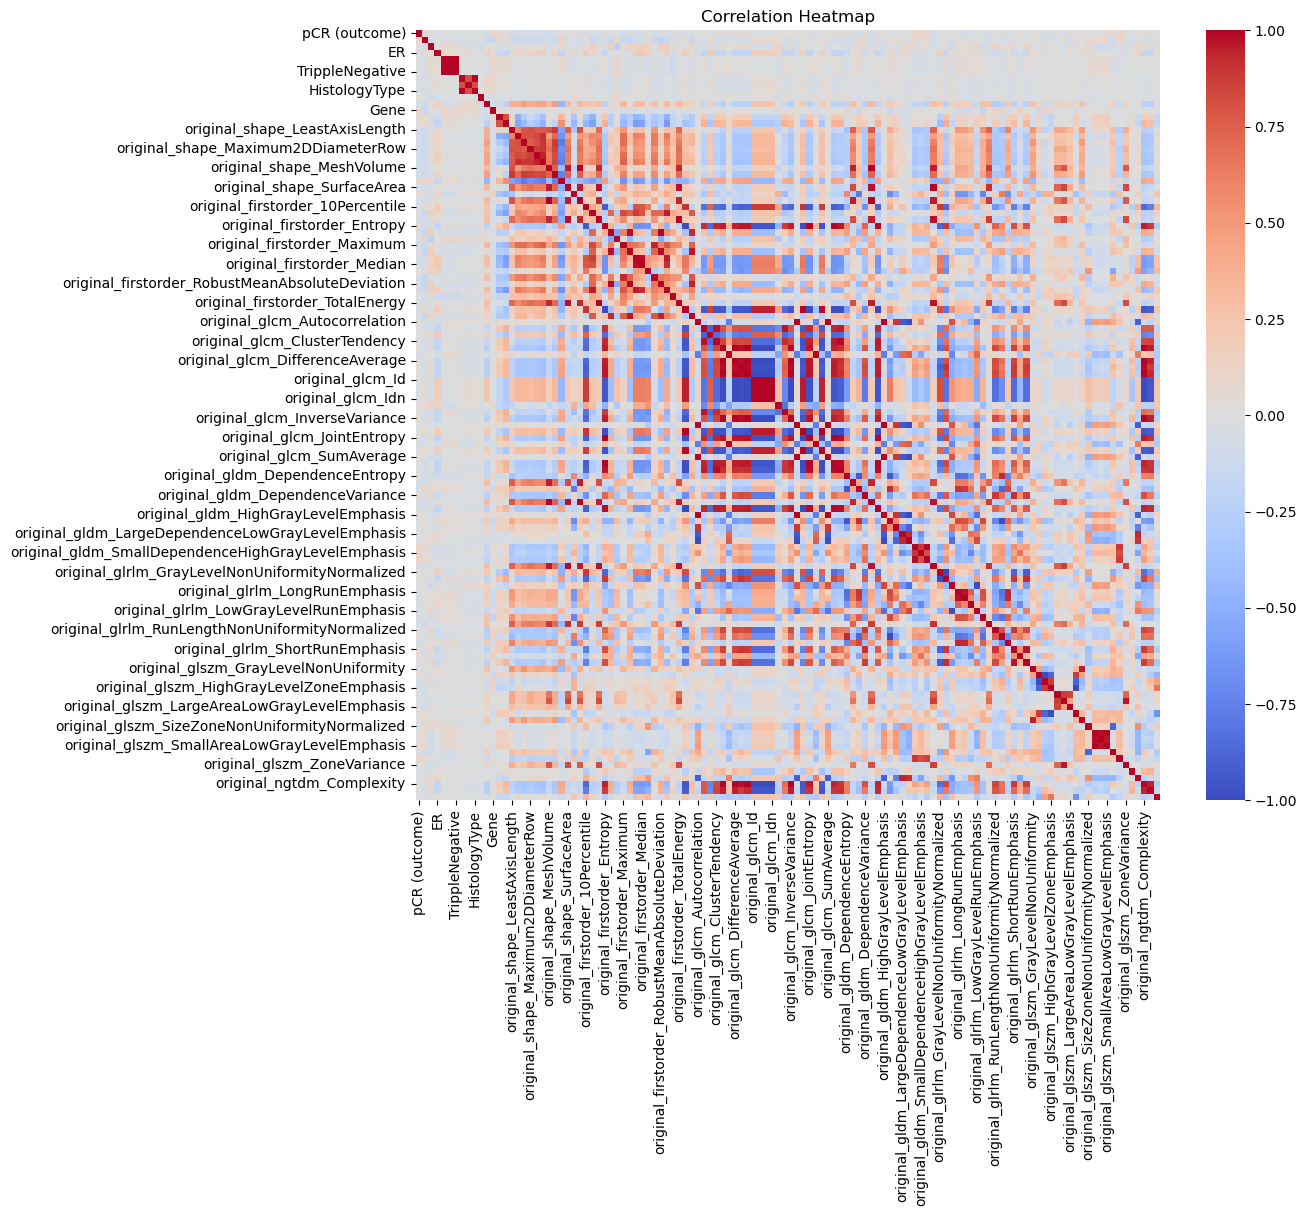

In [13]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.drop(columns=['ID']).corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title("Correlation Heatmap")
plt.show()

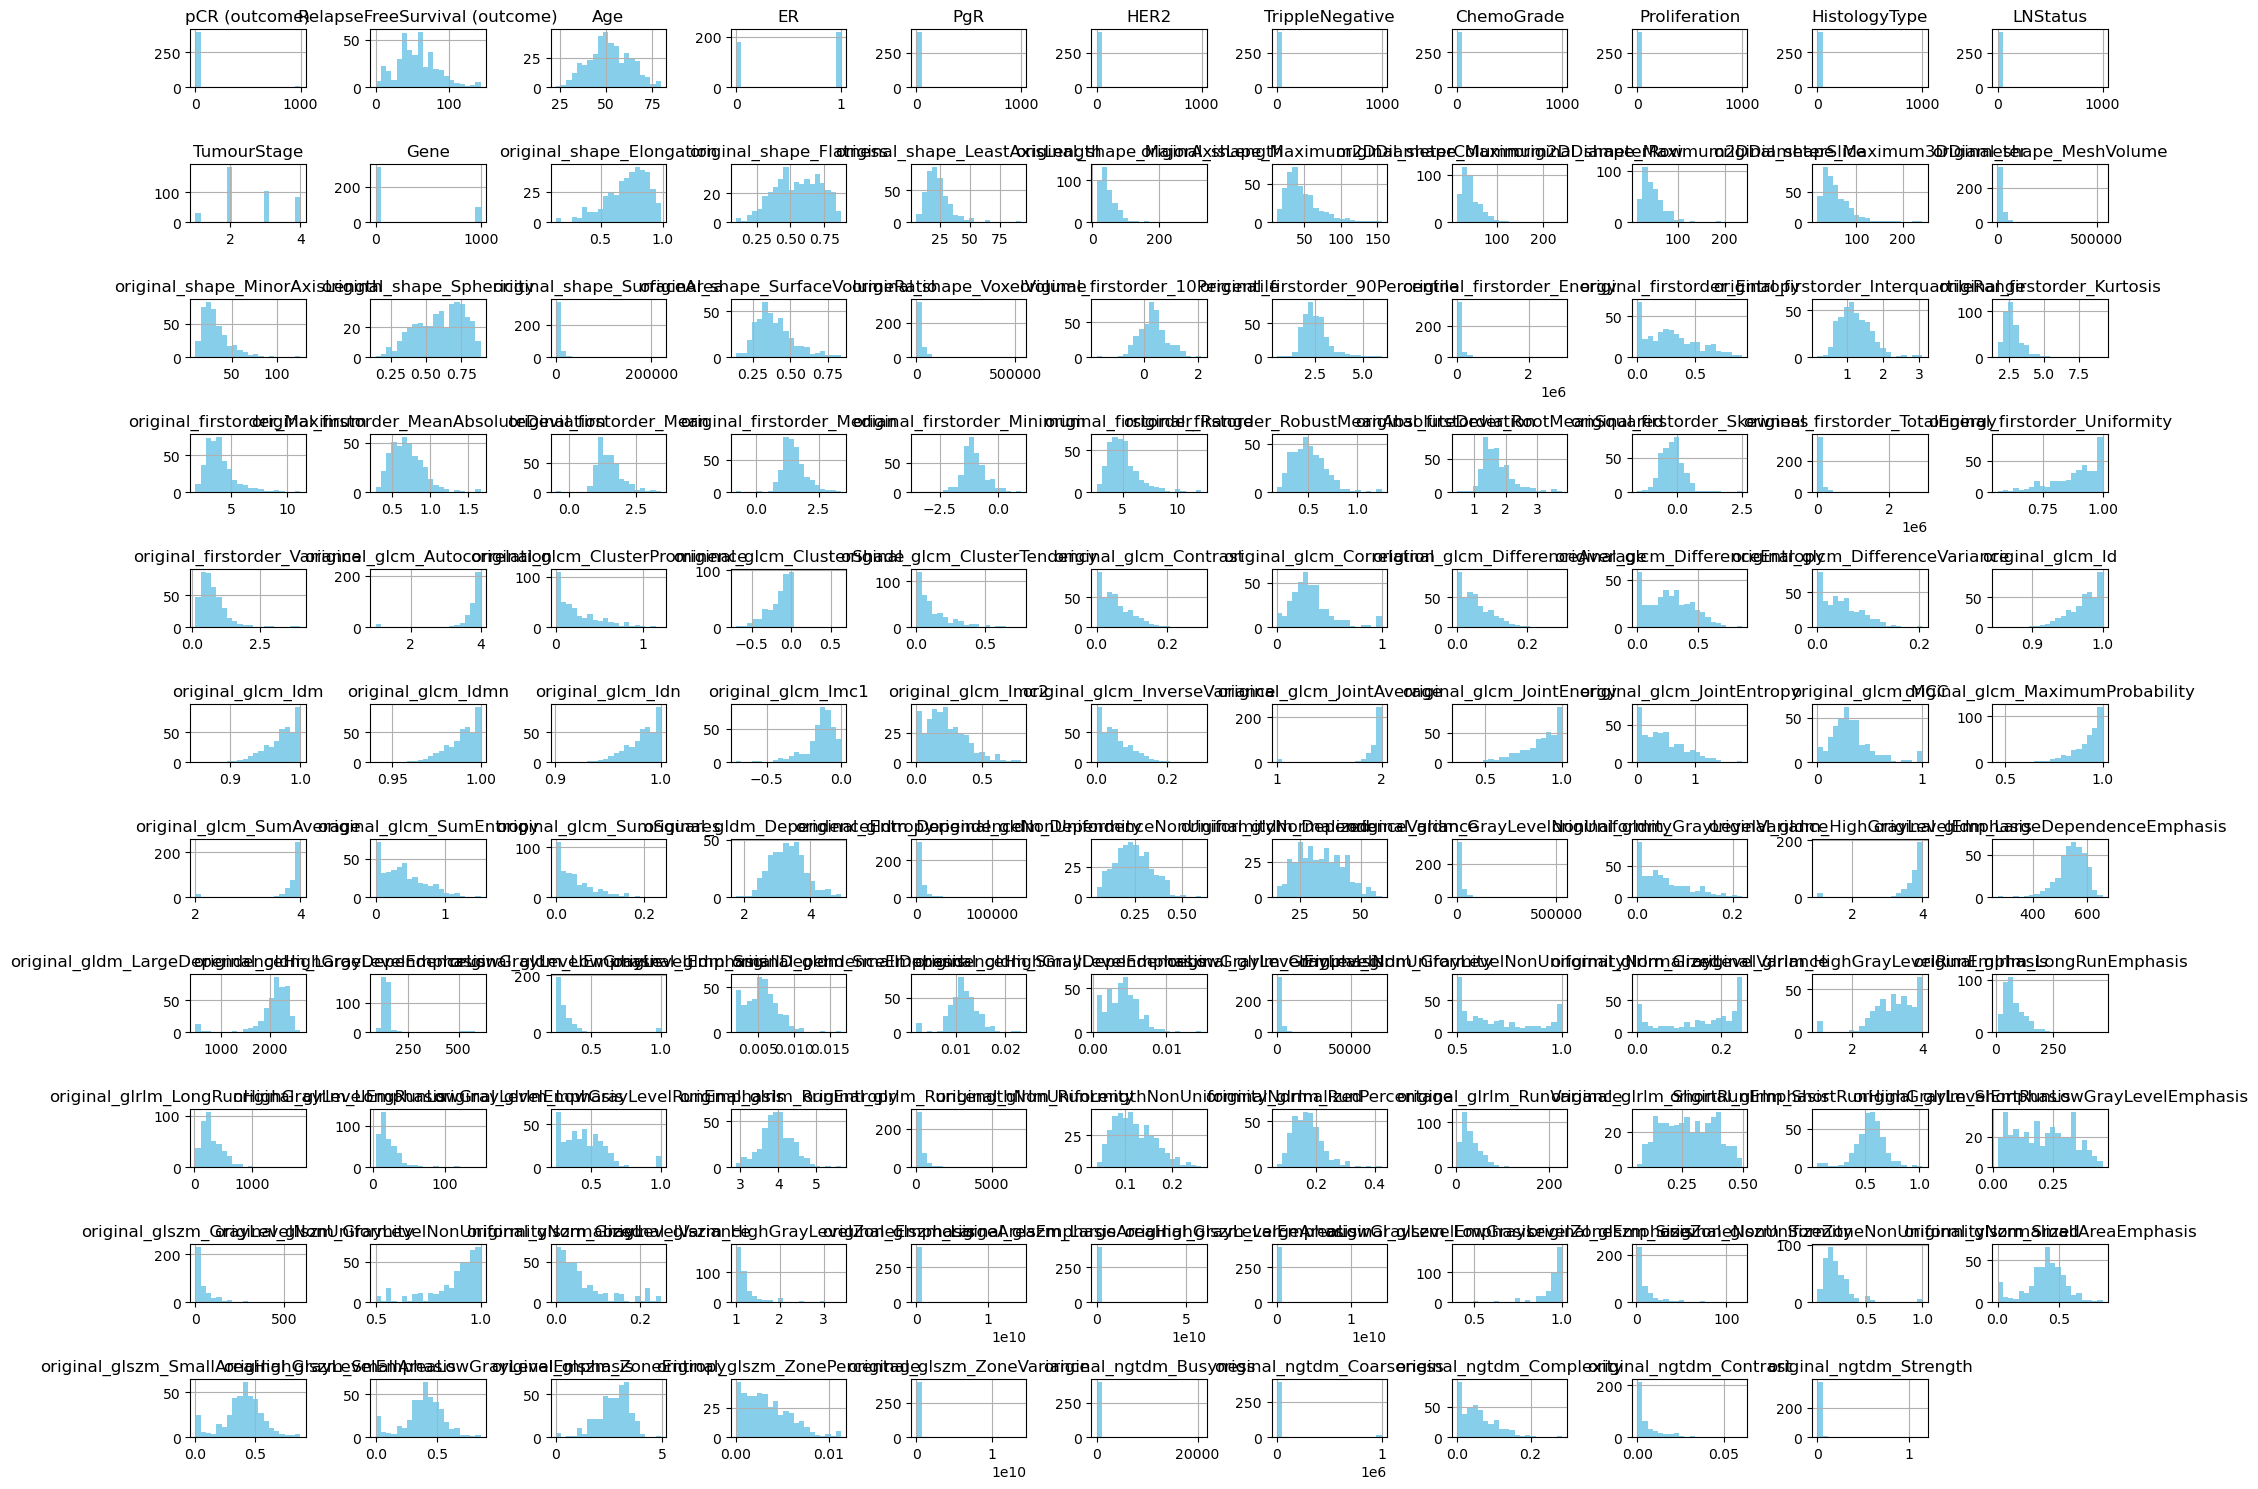

In [14]:
df.hist(bins=20, figsize=(20, 15), color="skyblue")
plt.tight_layout()
plt.show()

In [ ]:
df_cleaned = df.replace(999, np.nan)

In [53]:
temp_df = df_cleaned.drop(['ID', 'RelapseFreeSurvival (outcome)', 'pCR (outcome)'], axis=1)
temp_df.columns[(temp_df.nunique()>5)]
list(temp_df.columns[(temp_df.nunique()>10)])

['Age',
 'original_shape_Elongation',
 'original_shape_Flatness',
 'original_shape_LeastAxisLength',
 'original_shape_MajorAxisLength',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum2DDiameterSlice',
 'original_shape_Maximum3DDiameter',
 'original_shape_MeshVolume',
 'original_shape_MinorAxisLength',
 'original_shape_Sphericity',
 'original_shape_SurfaceArea',
 'original_shape_SurfaceVolumeRatio',
 'original_shape_VoxelVolume',
 'original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Mean',
 'original_firstorder_Median',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 '

- There are variables in the dataset that have positive and negative skewness
- These need to be handled later by techniques such as log-norm

In [ ]:
from scipy.stats import skew

def calculate_skewness(df):
    # Select continuous features (numerical columns only)
    numerical_cols = df.select_dtypes(include=["float64", "int64"])
    
    # Calculate skewness
    skewness = numerical_cols.apply(skew, axis=0)
    
    # Return skewness as a DataFrame
    return skewness.sort_values()

# Calculate skewness for all numerical columns
temp_df = df_cleaned.drop(['ID', 'RelapseFreeSurvival (outcome)', 'pCR (outcome)'], axis=1)
temp_df2 = temp_df[temp_df.columns[(temp_df.nunique()>5)]]
# list(temp_df.columns[(temp_df.nunique()>10)])
skewness_values = calculate_skewness(temp_df2)

<Axes: >

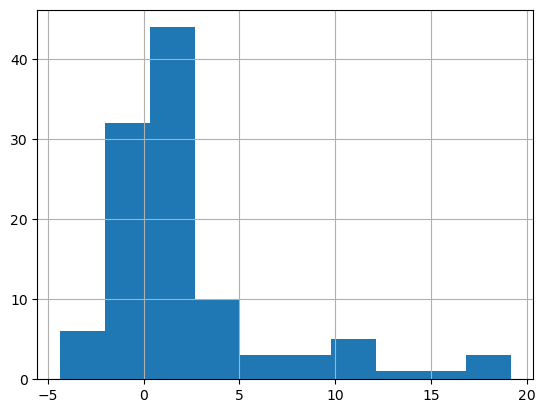

In [58]:
skewness_values.hist()

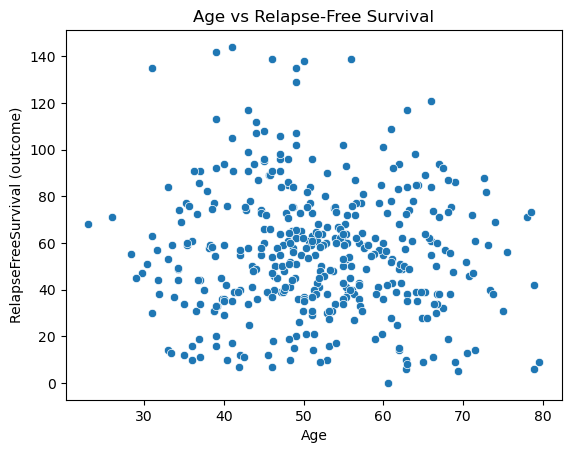

In [15]:
sns.scatterplot(x=df['Age'], y=df['RelapseFreeSurvival (outcome)'])
plt.title("Age vs Relapse-Free Survival")
plt.show()

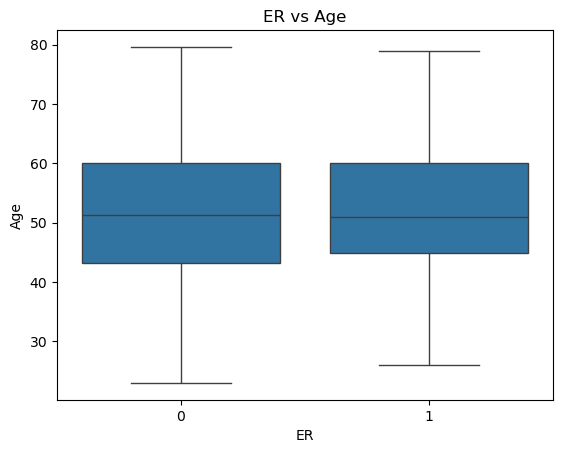

In [16]:
sns.boxplot(x=df['ER'], y=df['Age'])
plt.title("ER vs Age")
plt.show()

In [17]:
set(df.columns)

{'Age',
 'ChemoGrade',
 'ER',
 'Gene',
 'HER2',
 'HistologyType',
 'ID',
 'LNStatus',
 'PgR',
 'Proliferation',
 'RelapseFreeSurvival (outcome)',
 'TrippleNegative',
 'TumourStage',
 'original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_Mean',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Median',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Uniformity',
 'original_firstorder_Variance',
 'original_glcm_Autocorrelation',
 'original_glcm_ClusterProminence',
 'original_glcm_ClusterShade',
 'original_glcm_ClusterTendency',
 'original_glcm_Contrast',
 'original_glc

- The number 999 in the dataset represents missing values, here we replace them with numpy's nan.
- There are 9 columns with missing variables. 
- Most of these columns have less than 2% missing values except the column 'Gene' which has 88 missing values, making up 22% of the dataset.
- All of the columns with missing values are categorical in nature.

In [ ]:
    
# Count missing values
missing_values = df_cleaned.isna().sum()

# columns with missing values
df_cleaned.columns[(df_cleaned.isna().sum()>0)]

Index(['pCR (outcome)', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade',
       'Proliferation', 'HistologyType', 'LNStatus', 'Gene'],
      dtype='object')

In [19]:
missing_values[(missing_values>0)]

pCR (outcome)       5
PgR                 1
HER2                1
TrippleNegative     1
ChemoGrade          3
Proliferation       2
HistologyType       3
LNStatus            1
Gene               88
dtype: int64

In [20]:
df_cleaned['LNStatus'].value_counts()

LNStatus
1.0    213
0.0    186
Name: count, dtype: int64

In [21]:
df_cleaned['HistologyType'].value_counts()

HistologyType
1.0    338
2.0     59
Name: count, dtype: int64

In [22]:
df_cleaned['Proliferation'].value_counts()

Proliferation
1.0    237
2.0     93
3.0     68
Name: count, dtype: int64

In [23]:
df_cleaned['HER2'].value_counts()

HER2
0.0    279
1.0    120
Name: count, dtype: int64

In [24]:
df_cleaned['TrippleNegative'].value_counts()

TrippleNegative
0.0    266
1.0    133
Name: count, dtype: int64

In [25]:
df_cleaned['ChemoGrade'].value_counts()

ChemoGrade
2.0    234
3.0    161
1.0      2
Name: count, dtype: int64

In [26]:
df_cleaned['Gene'].value_counts()

Gene
0.0    193
1.0    119
Name: count, dtype: int64

In [27]:
df_cleaned['pCR (outcome)'].unique()

array([ 1.,  0., nan])

In [28]:
df_cleaned['pCR (outcome)'].value_counts()

pCR (outcome)
0.0    311
1.0     84
Name: count, dtype: int64

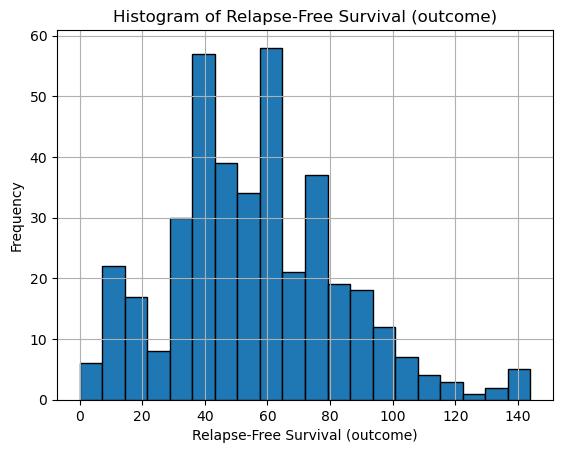

In [29]:
df_cleaned['RelapseFreeSurvival (outcome)'].hist(bins=20, edgecolor='black')
plt.xlabel('Relapse-Free Survival (outcome)')
plt.ylabel('Frequency')
plt.title('Histogram of Relapse-Free Survival (outcome)')
plt.show()

- All of the clinical features are categorical in nature while the MRI columns seems to have continous features.

In [30]:
dict(df_cleaned.nunique())

{'ID': 400,
 'pCR (outcome)': 2,
 'RelapseFreeSurvival (outcome)': 144,
 'Age': 321,
 'ER': 2,
 'PgR': 2,
 'HER2': 2,
 'TrippleNegative': 2,
 'ChemoGrade': 3,
 'Proliferation': 3,
 'HistologyType': 2,
 'LNStatus': 2,
 'TumourStage': 4,
 'Gene': 2,
 'original_shape_Elongation': 400,
 'original_shape_Flatness': 400,
 'original_shape_LeastAxisLength': 400,
 'original_shape_MajorAxisLength': 400,
 'original_shape_Maximum2DDiameterColumn': 332,
 'original_shape_Maximum2DDiameterRow': 326,
 'original_shape_Maximum2DDiameterSlice': 334,
 'original_shape_Maximum3DDiameter': 374,
 'original_shape_MeshVolume': 400,
 'original_shape_MinorAxisLength': 400,
 'original_shape_Sphericity': 400,
 'original_shape_SurfaceArea': 400,
 'original_shape_SurfaceVolumeRatio': 400,
 'original_shape_VoxelVolume': 397,
 'original_firstorder_10Percentile': 400,
 'original_firstorder_90Percentile': 400,
 'original_firstorder_Energy': 400,
 'original_firstorder_Entropy': 388,
 'original_firstorder_InterquartileRange

## One Hot Encoding

In [ ]:
df = pd.read_excel('TrainDataset2024.xls')

df_cleaned = df.replace(999, np.nan)
    
# Count missing values
missing_values = df_cleaned.isna().sum()

# columns with missing values
df_cleaned.columns[(df_cleaned.isna().sum()>0)]

train_data_rfs = df_cleaned.drop(['ID', 'pCR (outcome)'], axis=1)
X_rfs = train_data_rfs.drop(columns=['RelapseFreeSurvival (outcome)'], axis=1)
y_rfs = train_data_rfs['RelapseFreeSurvival (outcome)']

# Identify continuous and categorical variables
continuous_vars = X_rfs.columns[X_rfs.nunique() > 5]
categorical_vars = X_rfs.columns[(X_rfs.nunique() > 2) & (X_rfs.nunique() <= 5)]
binary_vars = X_rfs.columns[X_rfs.nunique() == 2]

In [ ]:
# One-hot encode the categorical variables
X_rfs_encoded = pd.get_dummies(X_rfs, columns=categorical_vars, drop_first=True)

# Display the first few rows to verify the changes
X_rfs_encoded.head()


,Age,ER,PgR,HER2,TrippleNegative,HistologyType,LNStatus,Gene,original_shape_Elongation,original_shape_Flatness,...,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,ChemoGrade_2.0,ChemoGrade_3.0,Proliferation_2.0,Proliferation_3.0,TumourStage_2,TumourStage_3,TumourStage_4
0,41.0,0,0.0,0.0,1.0,1.0,1.0,1.0,0.813912,0.724080,...,0.182615,0.030508,0.000758,False,True,False,True,True,False,False
1,39.0,1,1.0,0.0,0.0,1.0,1.0,0.0,0.666118,0.476173,...,0.032012,0.001006,0.003685,False,True,False,True,True,False,False
2,31.0,0,0.0,0.0,1.0,1.0,0.0,1.0,0.645083,0.594470,...,0.024062,0.000529,0.006447,True,False,False,False,True,False,False
3,35.0,0,0.0,0.0,1.0,1.0,1.0,1.0,0.770842,0.501228,...,0.013707,0.000178,0.004543,False,True,False,True,False,True,False
4,61.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.861035,0.750267,...,0.034148,0.001083,0.005626,True,False,False,False,True,False,False


# Data Cleaning

In [31]:
df_cleaned = df.replace(999, np.nan)
    
# Count missing values
missing_values = df_cleaned.isna().sum()

# columns with missing values
df_cleaned.columns[(df_cleaned.isna().sum()>0)]

Index(['pCR (outcome)', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade',
       'Proliferation', 'HistologyType', 'LNStatus', 'Gene'],
      dtype='object')

- The way to handle missing data depends on the type of missingness.
- There can be three types of missingness:
    - Missing completely at Random: The missing data has no relation to any observed or unobserved data
    - Missing at Random: The missing data can be explained by other observed features in the dataset
    - Missing not at Random: The missingness is attributed to the missing value itself or to unobserved features.

Reference: https://blog.dailydoseofds.com/p/missforest-and-knn-imputation-for    

In [6]:
from sklearn.impute import SimpleImputer, KNNImputer

mean_imputer = SimpleImputer(strategy='mean')
zero_imputer = SimpleImputer(strategy='constant', fill_value=0)

train_data = df_cleaned.drop(['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)

data_imputed_mean = mean_imputer.fit_transform(train_data)
data_imputed_zero = zero_imputer.fit_transform(train_data)

data_imputed_mean_df = pd.DataFrame(data_imputed_mean, columns=train_data.columns)
data_imputed_zero_df = pd.DataFrame(data_imputed_zero, columns=train_data.columns)

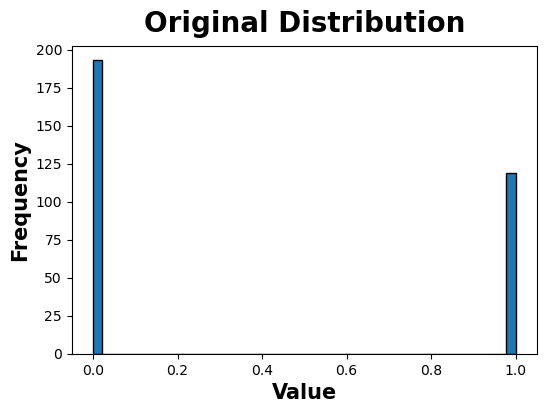

In [7]:
col_name = 'Gene'

X_feat = train_data[col_name]

fig, ax = plt.subplots(figsize=(6, 4))

# Original Distribution
ax.hist(X_feat, bins=45, edgecolor='black')
ax.set_title("Original Distribution", size = 20, weight="bold", pad = 10)
ax.set_xlabel("Value", size = 15, weight="bold")
ax.set_ylabel("Frequency", size = 15, weight="bold")

plt.show();

In [34]:
print('mean: ', data_imputed_mean_df[col_name].mean())
print('std: ', data_imputed_mean_df[col_name].std())

mean:  0.38141025641025633
std:  0.42952494445926104


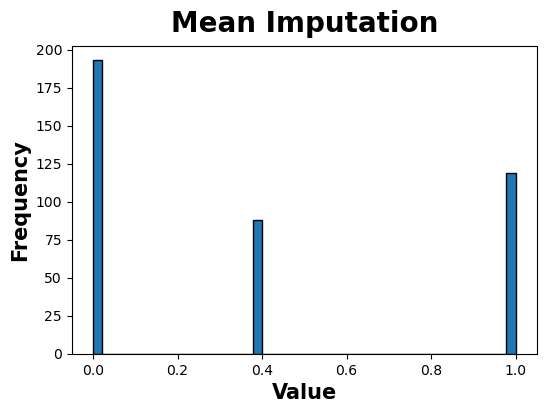

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(data_imputed_mean_df[col_name], bins=45, edgecolor='black')
ax.set_title("Mean Imputation", size = 20, weight="bold", pad = 10)
ax.set_xlabel("Value", size = 15, weight="bold")
ax.set_ylabel("Frequency", size = 15, weight="bold")

plt.show();

In [36]:
print('mean: ', data_imputed_mean_df[col_name].mean())
print('std: ', data_imputed_mean_df[col_name].std())

mean:  0.38141025641025633
std:  0.42952494445926104


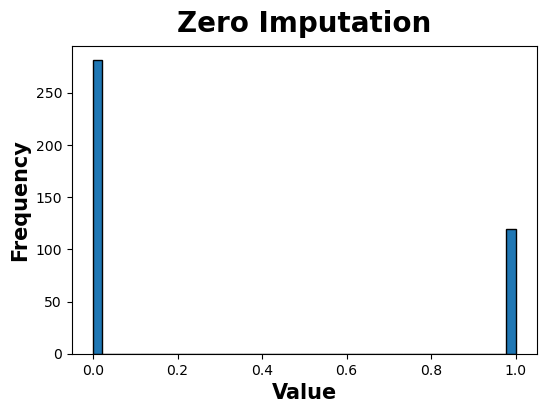

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(data_imputed_zero_df[col_name], bins=45, edgecolor='black')
ax.set_title("Zero Imputation", size = 20, weight="bold", pad = 10)
ax.set_xlabel("Value", size = 15, weight="bold")
ax.set_ylabel("Frequency", size = 15, weight="bold")

plt.show();

In [38]:
print('mean: ', data_imputed_mean_df[col_name].mean())
print('std: ', data_imputed_mean_df[col_name].std())

mean:  0.38141025641025633
std:  0.42952494445926104


In [39]:
knn_imputer = KNNImputer(n_neighbors=5)
data_imputed_knn = knn_imputer.fit_transform(train_data)

data_imputed_knn_df = pd.DataFrame(data_imputed_knn, columns=train_data.columns)

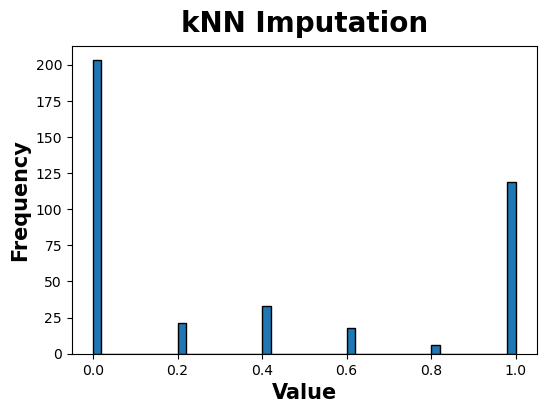

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(data_imputed_knn_df[col_name], bins=50, edgecolor='black')
ax.set_title("kNN Imputation", size = 20, weight="bold", pad = 10)
ax.set_xlabel("Value", size = 15, weight="bold")
ax.set_ylabel("Frequency", size = 15, weight="bold")

plt.show()


In [41]:
print('mean: ', data_imputed_mean_df[col_name].mean())
print('std: ', data_imputed_mean_df[col_name].std())

mean:  0.38141025641025633
std:  0.42952494445926104


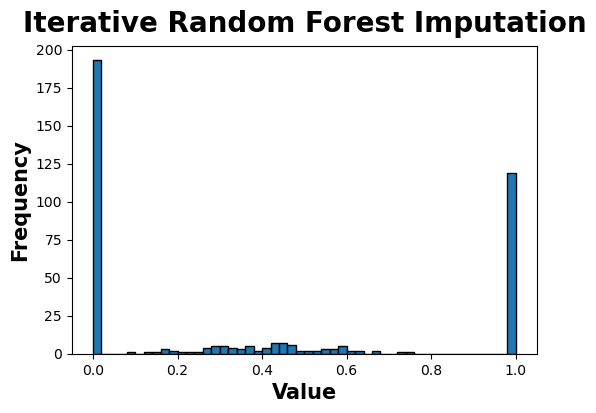

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

itr_imputer = IterativeImputer(estimator= RandomForestRegressor(),random_state=42)
data_imputed_itr = itr_imputer.fit_transform(train_data)
data_imputed_itr_df = pd.DataFrame(data_imputed_itr, columns=train_data.columns)

fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(data_imputed_itr_df[col_name], bins=50, edgecolor='black')
ax.set_title("Iterative Random Forest Imputation", size = 20, weight="bold", pad = 10)
ax.set_xlabel("Value", size = 15, weight="bold")
ax.set_ylabel("Frequency", size = 15, weight="bold")

plt.show()


# Feature Engineering

## Feature Importance

In [ ]:

df = pd.read_excel('TrainDataset2024.xls')

df_cleaned = df.replace(999, np.nan)

train_data_pcr = df_cleaned.drop(['ID', 'RelapseFreeSurvival (outcome)'], axis=1)
train_data_pcr = train_data_pcr[~train_data_pcr['pCR (outcome)'].isna()]

# Knn data imputation
knn_imputer = KNNImputer(n_neighbors=5)
data_imputed_knn = knn_imputer.fit_transform(train_data_pcr)

data_imputed_knn_df = pd.DataFrame(data_imputed_knn, columns=train_data_pcr.columns)

X_pcr = data_imputed_knn_df.drop(columns=['pCR (outcome)'], axis=1)
y_pcr = data_imputed_knn_df['pCR (outcome)']

categorical_vars = X_pcr.columns[(X_pcr.nunique() > 2) & (X_pcr.nunique() <= 5)]

# One-hot encode the categorical variables
X_pcr_encoded = pd.get_dummies(X_pcr, columns=categorical_vars, drop_first=True)

continuous_vars = X_pcr_encoded.columns[X_pcr_encoded.nunique() > 5]
categorical_vars = X_pcr_encoded.columns[X_pcr_encoded.nunique() <= 5]


# Apply StandardScaler only to continuous variables
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X_pcr_encoded[continuous_vars])

# Convert the scaled continuous variables back to a DataFrame
X_continuous_scaled_df = pd.DataFrame(X_continuous_scaled, columns=continuous_vars)

# Combine scaled continuous variables and categorical variables back into a single DataFrame
X_scaled = pd.concat([X_continuous_scaled_df, X_pcr_encoded[categorical_vars].reset_index(drop=True)], axis=1)

# Train a Random Forest model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_scaled, y_pcr)

# Extract feature importances
importances = clf.feature_importances_

# Combine feature names and importance values into a DataFrame
import pandas as pd
importance_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
1,Gene,0.057236
3,original_shape_Flatness,0.017617
30,original_firstorder_Skewness,0.016378
98,original_glszm_SmallAreaEmphasis,0.014924
70,original_gldm_SmallDependenceHighGrayLevelEmph...,0.013973
...,...,...
123,HistologyType_2.0,0.000283
124,LNStatus_0.6,0.000100
121,HistologyType_1.2,0.000000
117,Proliferation_1.2,0.000000


C:\Users\Alvin\AppData\Local\Temp\ipykernel_25216\2526889757.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance (%)', y='Feature', data=top_features, palette='coolwarm')


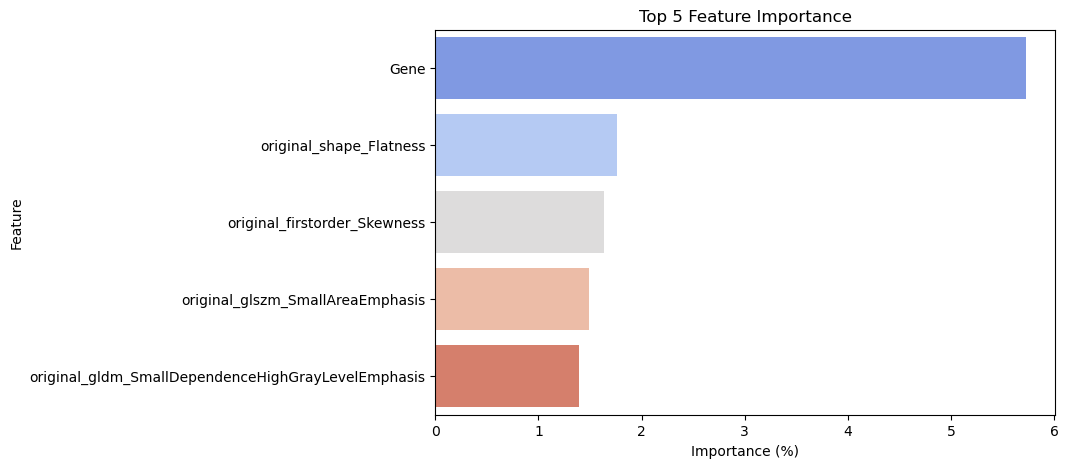

In [25]:
# Normalize feature importances
importance_df['Importance (%)'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100

# top 5 features
top_features = importance_df.head(5)

# Plot the top 5 features
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance (%)', y='Feature', data=top_features, palette='coolwarm')
plt.title('Top 5 Feature Importance')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.show()


In [26]:
importance_df

,Feature,Importance,Importance (%)
1,Gene,0.057236,5.723585
3,original_shape_Flatness,0.017617,1.761710
30,original_firstorder_Skewness,0.016378,1.637826
98,original_glszm_SmallAreaEmphasis,0.014924,1.492356
70,original_gldm_SmallDependenceHighGrayLevelEmph...,0.013973,1.397280
...,...,...,...
123,HistologyType_2.0,0.000283,0.028268
124,LNStatus_0.6,0.000100,0.009994
121,HistologyType_1.2,0.000000,0.000000
117,Proliferation_1.2,0.000000,0.000000


## PCA - Regression

In [33]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

df = pd.read_excel('TrainDataset2024.xls')

df_cleaned = df.replace(999, np.nan)

train_data_rfs = df_cleaned.drop(['ID', 'pCR (outcome)'], axis=1)

# Knn data imputation
knn_imputer = KNNImputer(n_neighbors=5)
data_imputed_knn = knn_imputer.fit_transform(train_data_rfs)

data_imputed_knn_df = pd.DataFrame(data_imputed_knn, columns=train_data_rfs.columns)

X_rfs = data_imputed_knn_df.drop(columns=['RelapseFreeSurvival (outcome)'], axis=1)
y_rfs = data_imputed_knn_df['RelapseFreeSurvival (outcome)']


categorical_vars = X_rfs.columns[(X_rfs.nunique() > 2) & (X_rfs.nunique() <= 5)]

# One-hot encode the categorical variables
X_rfs_encoded = pd.get_dummies(X_rfs, columns=categorical_vars, drop_first=True)

continuous_vars = X_rfs_encoded.columns[X_rfs_encoded.nunique() > 5]
categorical_vars = X_rfs_encoded.columns[X_rfs_encoded.nunique() <= 5]

# Apply StandardScaler only to continuous variables
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X_rfs_encoded[continuous_vars])

# Convert the scaled continuous variables back to a DataFrame
X_continuous_scaled_df = pd.DataFrame(X_continuous_scaled, columns=continuous_vars)

# Combine scaled continuous variables and categorical variables back into a single DataFrame
X_scaled = pd.concat([X_continuous_scaled_df, X_rfs_encoded[categorical_vars].reset_index(drop=True)], axis=1)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_rfs, test_size=0.2, random_state=42)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)  

# Fit and transform the training data
X_train_pca = pca.fit_transform(X_train)

# Transform the test data
X_test_pca = pca.transform(X_test)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Number of components:", pca.n_components_)


Explained variance ratio: [0.30235678 0.14801583 0.12866134 0.10324651 0.06056028 0.0484148
 0.02794454 0.02156861 0.02011728 0.01305745 0.01193712 0.0107857
 0.01044484 0.00898884 0.00808184 0.00782738 0.00717842 0.00568904
 0.00525955]
Number of components: 19


In [35]:
# Train a classifier (e.g., Random Forest)
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train_pca, y_train)

# Make predictions
y_pred = clf.predict(X_test_pca)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print("Model accuracy after PCA:", mae)


Model accuracy after PCA: 22.586739583333333


## PCA - Classification

In [27]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df = pd.read_excel('TrainDataset2024.xls')

df_cleaned = df.replace(999, np.nan)

train_data_pcr = df_cleaned.drop(['ID', 'RelapseFreeSurvival (outcome)'], axis=1)
train_data_pcr = train_data_pcr[~train_data_pcr['pCR (outcome)'].isna()]

# Knn data imputation
knn_imputer = KNNImputer(n_neighbors=5)
data_imputed_knn = knn_imputer.fit_transform(train_data_pcr)

data_imputed_knn_df = pd.DataFrame(data_imputed_knn, columns=train_data_pcr.columns)

X_pcr = data_imputed_knn_df.drop(columns=['pCR (outcome)'], axis=1)
y_pcr = data_imputed_knn_df['pCR (outcome)']

categorical_vars = X_pcr.columns[(X_pcr.nunique() > 2) & (X_pcr.nunique() <= 5)]

# One-hot encode the categorical variables
X_pcr_encoded = pd.get_dummies(X_pcr, columns=categorical_vars, drop_first=True)

continuous_vars = X_pcr_encoded.columns[X_pcr_encoded.nunique() > 5]
categorical_vars = X_pcr_encoded.columns[X_pcr_encoded.nunique() <= 5]

# Apply StandardScaler only to continuous variables
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X_pcr_encoded[continuous_vars])

# Convert the scaled continuous variables back to a DataFrame
X_continuous_scaled_df = pd.DataFrame(X_continuous_scaled, columns=continuous_vars)

# Combine scaled continuous variables and categorical variables back into a single DataFrame
X_scaled = pd.concat([X_continuous_scaled_df, X_pcr_encoded[categorical_vars].reset_index(drop=True)], axis=1)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_pcr, test_size=0.2, random_state=42)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)  

# Fit and transform the training data
X_train_pca = pca.fit_transform(X_train)

# Transform the test data
X_test_pca = pca.transform(X_test)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Number of components:", pca.n_components_)


Explained variance ratio: [0.29912416 0.15306108 0.11917864 0.11253907 0.06175622 0.04644278
 0.03222169 0.02133575 0.02066645 0.01251805 0.0119475  0.01018387
 0.00932749 0.00821028 0.00813556 0.00755638 0.00620623 0.00599252
 0.00533185]
Number of components: 19


In [29]:
# Train a classifier (e.g., Random Forest)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train)

# Make predictions
y_pred = clf.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy after PCA:", accuracy)


Model accuracy after PCA: 0.810126582278481


In [30]:
from sklearn.metrics import balanced_accuracy_score

accuracy = balanced_accuracy_score(y_test, y_pred)
print("Model balanced accuracy after PCA:", accuracy)

Model balanced accuracy after PCA: 0.5545634920634921


In [31]:
pca = PCA()
pca.fit(X_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative explained variance:", cumulative_variance)


Cumulative explained variance: [0.31230718 0.45226308 0.57004426 0.68053871 0.74029796 0.78631827
 0.81703243 0.83850089 0.85758359 0.87027883 0.88116174 0.89186694
 0.90186391 0.91088819 0.91906879 0.92708359 0.93446148 0.94058014
 0.94609507 0.95144958 0.95655948 0.9602798  0.96381385 0.9667385
 0.96934287 0.97162348 0.97367998 0.97571154 0.97770658 0.97956766
 0.9813087  0.98294748 0.98445628 0.9857687  0.98696592 0.98810018
 0.9891579  0.99020679 0.99112229 0.99195772 0.99273037 0.99349029
 0.99416054 0.99472492 0.99525551 0.9957374  0.99616764 0.99656557
 0.99693069 0.99725144 0.99751596 0.99775876 0.99798773 0.99819215
 0.99838831 0.99853325 0.99867189 0.99879676 0.9989191  0.99903805
 0.99914859 0.99924822 0.99933394 0.9994143  0.99948927 0.99955973
 0.99962313 0.99967743 0.99972721 0.99977513 0.99981807 0.99985455
 0.99988028 0.99990104 0.99991889 0.99993102 0.99994249 0.99995187
 0.99996014 0.9999662  0.99997205 0.99997724 0.99998154 0.99998508
 0.99998824 0.99999083 0.9999930

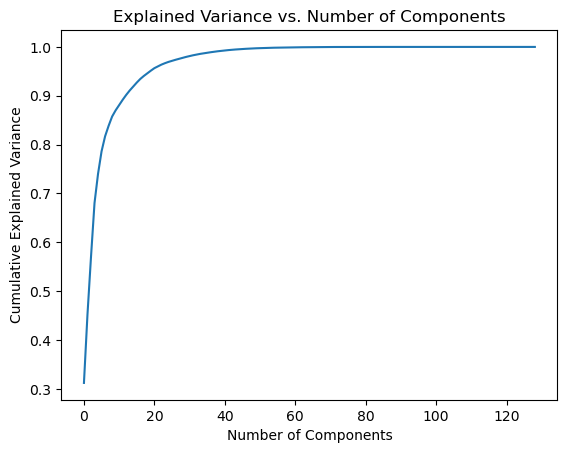

In [32]:
import matplotlib.pyplot as plt

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()


# Model Building

## Regression to predict RFS

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin

class DataFrameTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)
    

df = pd.read_excel('TrainDataset2024.xls')

df_cleaned = df.replace(999, np.nan)
    
# Count missing values
missing_values = df_cleaned.isna().sum()

# columns with missing values
df_cleaned.columns[(df_cleaned.isna().sum()>0)]

train_data_rfs = df_cleaned.drop(['ID', 'pCR (outcome)'], axis=1)
X_rfs = train_data_rfs.drop(columns=['RelapseFreeSurvival (outcome)'], axis=1)
y_rfs = train_data_rfs['RelapseFreeSurvival (outcome)']

categorical_vars = X_rfs.columns[(X_rfs.nunique() > 2) & (X_rfs.nunique() <= 5)]

# One-hot encode the categorical variables
X_rfs_encoded = pd.get_dummies(X_rfs, columns=categorical_vars, drop_first=True)

# Identify continuous and categorical variables
continuous_vars = X_rfs_encoded.columns[X_rfs_encoded.nunique() > 5]
categorical_vars = X_rfs_encoded.columns[X_rfs_encoded.nunique() <= 5]

preprocessor = Pipeline([
    ('imputer', KNNImputer(n_neighbors=2)),  # Step 1: Impute missing values
    ('to_dataframe', DataFrameTransformer(columns=X_rfs_encoded.columns)),
    ('scaler', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), continuous_vars),  # Scale continuous variables
            ('cat', 'passthrough', categorical_vars)  # Use already one-hot encoded variables
        ]
    ))
])


# Define different regressors
regressors = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf'),
    'KNeighbors': KNeighborsRegressor(n_neighbors=5),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100,), activation='relu', max_iter=500, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Create pipelines for each regressor
pipelines = {name: Pipeline([('preprocessor', preprocessor), ('regressor', reg)]) for name, reg in regressors.items()}

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_rfs_encoded, y_rfs, test_size=0.2, random_state=42)

# Define a custom scoring metric (Mean Absolute Error in this case)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

results = {}

for name, pipeline in pipelines.items():
        
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(pipeline, X_rfs_encoded, y_rfs, cv=5, scoring=mae_scorer)
    cv_scores = -cv_scores  # Convert scores to positive

    results[name] = {
        'cv_scores': cv_scores,
        'cv_mean_mae': cv_scores.mean(),
        'cv_std_mae': cv_scores.std()
    }
    
    print(f"Model: {name}")
    print(f"Cross-Validation MAE Scores: {cv_scores}")
    print(f"Mean CV MAE: {cv_scores.mean():.4f}")
    print(f"Standard Deviation of CV MAE: {cv_scores.std():.4f}")
    print()



Model: LinearRegression
Cross-Validation MAE Scores: [ 46.58166963 255.53322579 142.88298966  26.39074975  28.37197576]
Mean CV MAE: 99.9521
Standard Deviation of CV MAE: 88.8053

Model: RandomForest
Cross-Validation MAE Scores: [42.371      20.66496875 13.369375   22.446125   14.47441667]
Mean CV MAE: 22.6652
Standard Deviation of CV MAE: 10.4486

Model: GradientBoosting
Cross-Validation MAE Scores: [41.44718977 20.44063414 15.20903986 22.47812835 16.48885651]
Mean CV MAE: 23.2128
Standard Deviation of CV MAE: 9.4867

Model: AdaBoost
Cross-Validation MAE Scores: [41.64791667 21.17291667 15.071875   23.115625   16.740625  ]
Mean CV MAE: 23.5498
Standard Deviation of CV MAE: 9.5039

Model: SVR
Cross-Validation MAE Scores: [43.00675994 22.46846099 11.91787958 24.0879602  14.69016961]
Mean CV MAE: 23.2342
Standard Deviation of CV MAE: 10.8934

Model: KNeighbors
Cross-Validation MAE Scores: [44.655      23.41020833 16.07229167 23.58125    16.221875  ]
Mean CV MAE: 24.7881
Standard Deviatio

c:\Users\Alvin\miniconda3\envs\MLa2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Alvin\miniconda3\envs\MLa2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Alvin\miniconda3\envs\MLa2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Alvin\miniconda3\envs\MLa2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Alvin\miniconda3\en

Model: MLPRegressor
Cross-Validation MAE Scores: [40.87252057 20.82423273 21.71636377 20.6240145  20.35549927]
Mean CV MAE: 24.8785
Standard Deviation of CV MAE: 8.0100

Model: XGBoost
Cross-Validation MAE Scores: [41.41642199 19.14367373 14.62534261 22.86145215 16.91738142]
Mean CV MAE: 22.9929
Standard Deviation of CV MAE: 9.6040



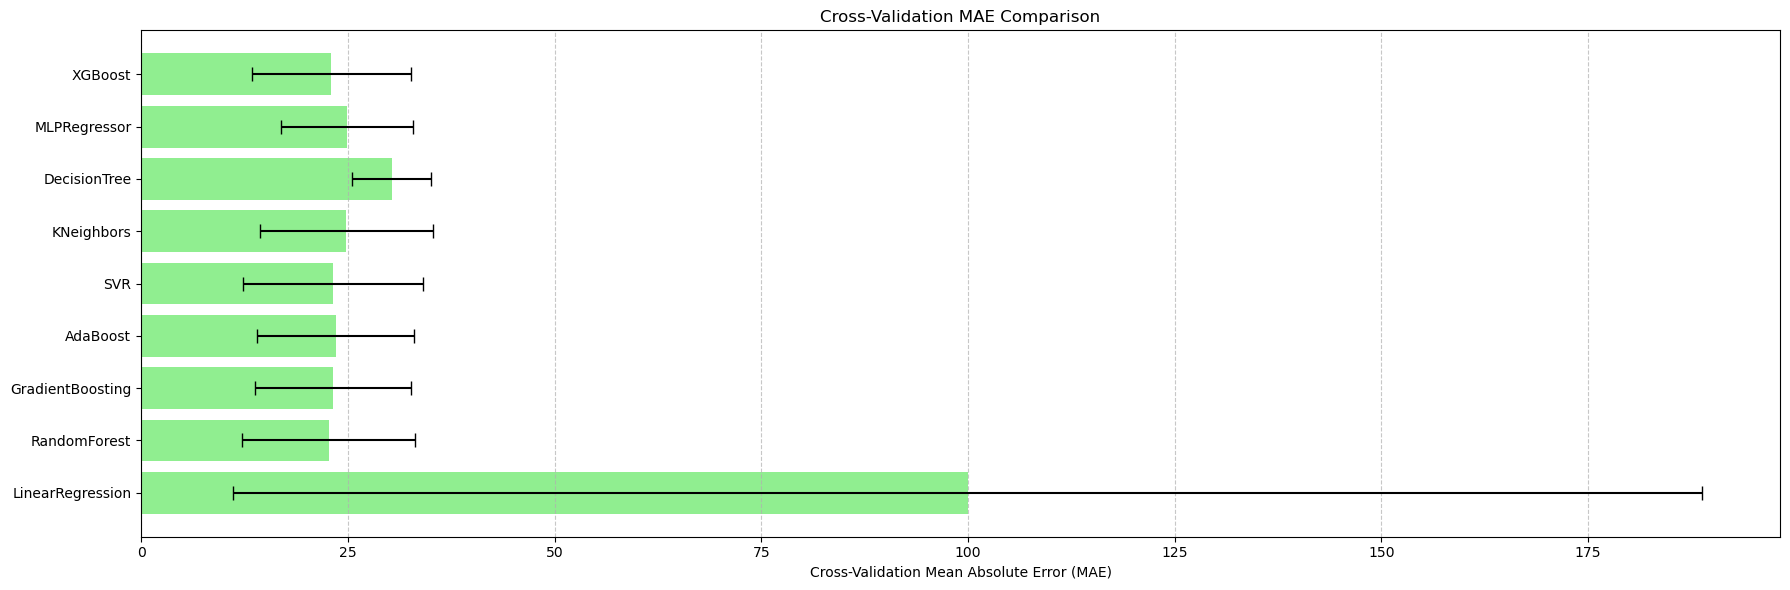

In [20]:
# Extract model names and their corresponding metrics
model_names = list(results.keys())
cv_mean_mae = [results[name]['cv_mean_mae'] for name in model_names]
cv_std_mae = [results[name]['cv_std_mae'] for name in model_names]

# Create bar plots for MAE, MSE, and CV MAE
plt.figure(figsize=(18, 6))

# Cross-Validation MAE Plot
plt.subplot(1, 1, 1)
plt.barh(model_names, cv_mean_mae, xerr=cv_std_mae, color='lightgreen', capsize=5)
plt.xlabel('Cross-Validation Mean Absolute Error (MAE)')
plt.title('Cross-Validation MAE Comparison')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


## Classification to clasify pCR

Running Cross-Validation for LogisticRegression...
Model: LogisticRegression
Cross-Validation Accuracy Scores: [0.78481013 0.82278481 0.70886076 0.82278481 0.83544304]
Mean CV Accuracy: 0.7949
Standard Deviation of CV Accuracy: 0.0463

Running Cross-Validation for RandomForest...
Model: RandomForest
Cross-Validation Accuracy Scores: [0.78481013 0.78481013 0.75949367 0.81012658 0.81012658]
Mean CV Accuracy: 0.7899
Standard Deviation of CV Accuracy: 0.0189

Running Cross-Validation for GradientBoosting...
Model: GradientBoosting
Cross-Validation Accuracy Scores: [0.74683544 0.7721519  0.73417722 0.81012658 0.7721519 ]
Mean CV Accuracy: 0.7671
Standard Deviation of CV Accuracy: 0.0261

Running Cross-Validation for AdaBoost...
Model: AdaBoost
Cross-Validation Accuracy Scores: [0.65822785 0.72151899 0.65822785 0.69620253 0.75949367]
Mean CV Accuracy: 0.6987
Standard Deviation of CV Accuracy: 0.0387

Running Cross-Validation for SVC...
Model: SVC
Cross-Validation Accuracy Scores: [0.78481013

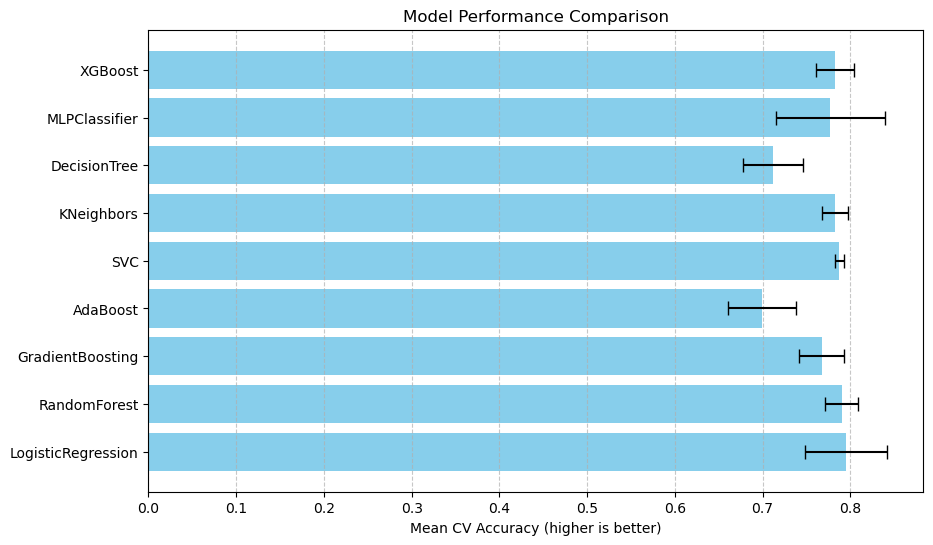

Best Model: LogisticRegression
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87        63
         1.0       0.44      0.25      0.32        16

    accuracy                           0.78        79
   macro avg       0.64      0.59      0.60        79
weighted avg       0.75      0.78      0.76        79



In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin

class DataFrameTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)
    

# Load dataset
df = pd.read_excel('TrainDataset2024.xls')

# Replace placeholder missing values
df_cleaned = df.replace(999, np.nan)

# Select features and target
train_data_pcr = df_cleaned.drop(['ID', 'RelapseFreeSurvival (outcome)'], axis=1)
train_data_pcr = train_data_pcr[~train_data_pcr['pCR (outcome)'].isna()]

X_pcr = train_data_pcr.drop(columns=['pCR (outcome)'], axis=1)
y_pcr = train_data_pcr['pCR (outcome)']

categorical_vars = X_pcr.columns[(X_pcr.nunique() > 2) & (X_pcr.nunique() <= 5)]

# One-hot encode the categorical variables
X_pcr_encoded = pd.get_dummies(X_pcr, columns=categorical_vars, drop_first=True)

# Identify continuous and categorical variables
continuous_vars = X_pcr_encoded.columns[X_pcr_encoded.nunique() > 5]
categorical_vars = X_pcr_encoded.columns[X_pcr_encoded.nunique() <= 5]


preprocessor = Pipeline([
    ('imputer', KNNImputer(n_neighbors=2)),  # Step 1: Impute missing values
    ('to_dataframe', DataFrameTransformer(columns=X_pcr_encoded.columns)),
    ('scaler', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), continuous_vars),  # Scale continuous variables
            ('cat', 'passthrough', categorical_vars)  # Use already one-hot encoded variables
        ]
    ))
])

# Define different classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42),
    'SVC': SVC(kernel='rbf', probability=True, random_state=42),
    'KNeighbors': KNeighborsClassifier(n_neighbors=5),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=500, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Create pipelines for each classifier
pipelines = {name: Pipeline([('preprocessor', preprocessor), ('classifier', clf)]) for name, clf in classifiers.items()}

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_pcr_encoded, y_pcr, test_size=0.2, random_state=42)

# Define a custom scoring metric (Accuracy in this case)
accuracy_scorer = make_scorer(accuracy_score)

results = {}

for name, pipeline in pipelines.items():
    print(f"Running Cross-Validation for {name}...")
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(pipeline, X_pcr_encoded, y_pcr, cv=5, scoring=accuracy_scorer, n_jobs=-1)
    
    # Store results
    results[name] = {
        'cv_scores': cv_scores,
        'cv_mean_accuracy': cv_scores.mean(),
        'cv_std_accuracy': cv_scores.std()
    }
    
    print(f"Model: {name}")
    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
    print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.4f}")
    print()

# Visualize results
model_names = list(results.keys())
cv_mean_accuracy = [results[name]['cv_mean_accuracy'] for name in model_names]
cv_std_accuracy = [results[name]['cv_std_accuracy'] for name in model_names]

# Bar plot for cross-validation results
plt.figure(figsize=(10, 6))
plt.barh(model_names, cv_mean_accuracy, xerr=cv_std_accuracy, color='skyblue', capsize=5)
plt.xlabel('Mean CV Accuracy (higher is better)')
plt.title('Model Performance Comparison')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Fit and evaluate the best model (based on mean accuracy) on the validation set
best_model_name = max(results, key=lambda name: results[name]['cv_mean_accuracy'])
best_pipeline = pipelines[best_model_name]
best_pipeline.fit(X_train, y_train)

# Predict on the validation set
y_pred = best_pipeline.predict(X_val)

# Print classification report
print(f"Best Model: {best_model_name}")
print(classification_report(y_val, y_pred))


c:\Users\Alvin\miniconda3\envs\MLa2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


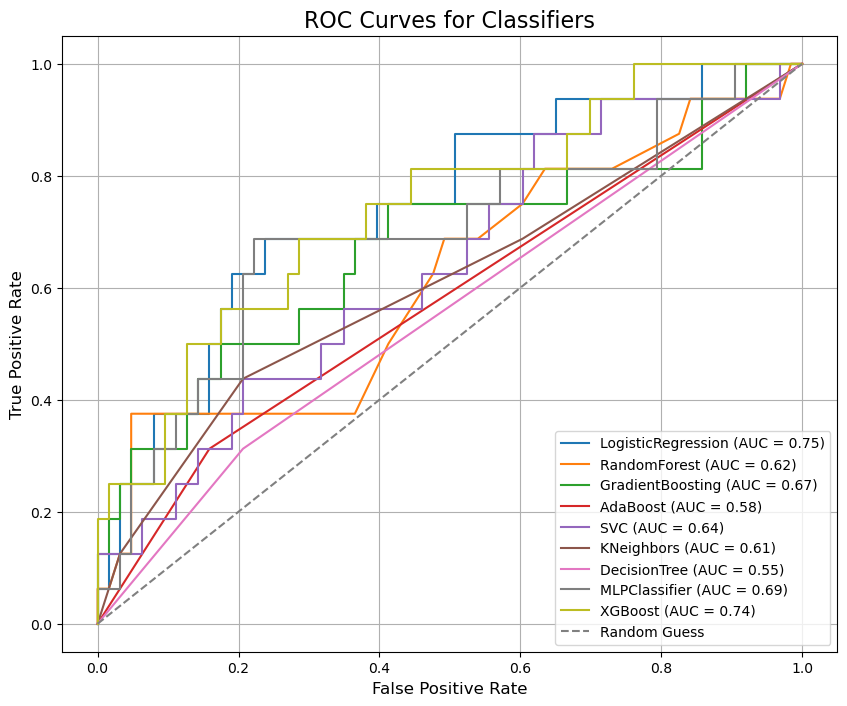

Classification Report for LogisticRegression:

              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87        63
         1.0       0.44      0.25      0.32        16

    accuracy                           0.78        79
   macro avg       0.64      0.59      0.60        79
weighted avg       0.75      0.78      0.76        79

------------------------------------------------------------
Classification Report for RandomForest:

              precision    recall  f1-score   support

         0.0       0.81      0.97      0.88        63
         1.0       0.50      0.12      0.20        16

    accuracy                           0.80        79
   macro avg       0.66      0.55      0.54        79
weighted avg       0.75      0.80      0.75        79

------------------------------------------------------------
Classification Report for GradientBoosting:

              precision    recall  f1-score   support

         0.0       0.84      0.90   

c:\Users\Alvin\miniconda3\envs\MLa2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alvin\miniconda3\envs\MLa2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alvin\miniconda3\envs\MLa2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, classification_report

# Initialize a dictionary to store ROC data
roc_data = {}

# Loop through models and evaluate ROC AUC
plt.figure(figsize=(10, 8))
for name, pipeline in pipelines.items():
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Get predicted probabilities or decision scores
    if hasattr(pipeline['classifier'], "predict_proba"):
        y_scores = pipeline.predict_proba(X_val)[:, 1]
    else:  # For classifiers like SVM, use decision_function
        y_scores = pipeline.decision_function(X_val)
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot diagonal line for random guess
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')

# Add labels, title, and legend
plt.title('ROC Curves for Classifiers', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print classification reports for all models
for name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_val)
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_val, y_pred))
    print("-" * 60)
